## MD Product Analytics

MD has started building its fleet of robocars and is planning to deploy it in ridesharing service business in San Francisco Bay Area (San Francisco and surrounding areas). With the help of publicly available Travel Decision survey data from residents of Bay Area, it needs data-driven analysis to carry out following strategic decisions.

1)	Market Selection: Which of the following markets should MD launch ridesharing in? 

    a) Residents of SF, operating within the boundaries of the city, or

    b) Residents of other adjoining and nearby counties to commute into and out of SF.

2)	Marketing Segmentation: Which specific groups of customers (age, gender, race, or any combination thereof) should MD target as its first set of customers and why?

In [1]:
# import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# set seaborn visualization settings
sns.set_context('notebook')
sns.set_style('ticks')

# remove column length restriction in output of jupyter notebook
pd.set_option('display.max_colwidth', -1)

In [2]:
# extract survey data from csv to pandas dataframe for further analysis
df = pd.read_csv("data/raw/travel_survey.csv", parse_dates=['Interview_Date'])

# lower the case of column names for ease of reference
df.columns = df.columns.str.lower()

# display sample records
df.head(2)

,respnum,q2,q3,trips,q4tot,q5tot,q4ap,q4bp,q4cp,q4dp,...,q29,q30,sampletype,lang,zone,interview_date,interview_day,drvrflag,ageco,weight
0,2,1,1.0,19,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,2,1,NaN,2017-02-07,3,1.0,9,0.773209
1,3,9,NaN,4,2.0,2.0,1.0,5.0,NaN,NaN,...,6,2,2,1,2.0,2017-02-07,3,1.0,4,1.069729


### Data Wrangling

In [3]:
# derive an attribute to identify SF and non-SF residents 
# club all the other county residents under one value
df['sf_resident'] = df.q2.apply(lambda x: 1 if x==9 else 0)

# proportion of SF and non-SF residents in the survey daa
df['sf_resident'].value_counts()

# looks like a neatly balanced data wrt to SF and non-SF residents

0    403
1    401
Name: sf_resident, dtype: int64

In [4]:
# county value map
cntyMap = {1:'Alameda', 2:'Contra Costa', 3:'Marin', 4:'Napa', 5:'San Mateo', 6:'Santa Clara',
           7:'Solano', 8:'Sonoma', 9:'San Francisco'}

# rename q2 to county code
df.rename(columns={'q2':'county_code'}, inplace=True)

# replace number values with county names
df['county'] = df['county_code'].replace(cntyMap)

# map given codes to age ranges 
df.loc[:,'age_code'] = df['q27']
df.loc[:,'age'] = df['age_code'].replace({1:'18-24', 2:'25-34', 3:'35-44', 4:'45-54', 5:'55-64', 6:'65+', 7:'Unknown'})

# map given income codes to income ranges
df.loc[:,'income_code'] = df['q29']
df.loc[:,'income'] = df['income_code'].replace({1:'Less than 15k', 2:'15k-25k', 3:'25k-35k', 
                                                4:'35k-75k', 5:'75k-100k', 6:'100k-200k',
                                                7:'More than 200k', 8: 'Unknown'})

# elaborate gender
df.loc[:,'gender_code'] = df['q30']
df.loc[:,'gender'] = df['gender_code'].replace({1:'Male', 2:'Female', 3:'Non-Binary'})

# elaborate reasons for driving own car
df[['free_parking','cheap_parking','close_parking','driving_faster','driving_safer','multiple_stops','with_children',
    'carry_something']] = df[['q22a', 'q22b', 'q22c', 'q22d', 'q22e', 'q22f', 'q22g',
                              'q22h']].fillna(0).astype('int').replace({2:0, 3:0})

# create a flag to indicate if at least one of the factors to drive was a hard reason
df['car_reason_hard'] = df[['multiple_stops','with_children',
                            'carry_something']].apply(lambda x: 1 if (x[0]==1 or x[1]==1 or x[2]==1) else 0, axis=1)

# categorize current usage of uber/lyft and taxis
# 1 denotes regular usage, 0 denotes rarely, and -1 denotes never
df['uber_usage'] = df.q21a.replace({1:-1, 6:-1, 5:0, 4:0, 2:1, 3:1})
df['taxi_usage'] = df.q21c.replace({1:-1, 6:-1, 5:0, 4:0, 2:1, 3:1})

# race code map
raceMap = {1:'Asian', 2:'African American', 3:'Hispanic/Latino', 4:'White', 5:'Native American',
           6:'Other', 7:'Refused', 8:'Mixed (Unspecified)'}

# replace number codes with race names
df.loc[:,'race_code'] = df['q28_1']
df['race'] = df['race_code'].replace(raceMap)

# For SF, average distance of a ride/commute within SF
# For other counties, average distance to travel to SF
avgTravelDist= {'Alameda':55, 'Contra Costa':40, 'Marin':40, 'Napa':65, 'San Mateo':30, 'Santa Clara':50,
                'Solano':60, 'Sonoma':80, 'San Francisco':5}

# replace number values with county names
df['avg_travel_dist'] = df['county'].replace(avgTravelDist)

In [5]:
# lets assume that what SF commuters experienced in last 2 days is a good reflection of what they experience all workdays
# so, multiply the number of rides in last 2 days with 11 to get total trips over weekdays for last month
num_days_sf = 11

# calculate number of trips for each high-level mode of transport for SF residents

df['car_trips'] = df[['da', 'do', 'crshre']].fillna(0).apply(lambda x: sum(x) * num_days_sf, axis=1)
df['taxi_trips'] = df[['tnc', 'taxi']].fillna(0).apply(lambda x: sum(x) * num_days_sf, axis=1)

df[['public_trips','mass_private_trips']] = df[['trans','shttle']].apply(lambda x: x * num_days_sf, axis=1)

df['legs_trips'] = df[['bike', 'walk']].fillna(0).apply(lambda x: sum(x) * num_days_sf, axis=1)
df['other_trips'] = df[['scoot', 'oth-m-sf', 'dk-m-sf']].fillna(0).apply(lambda x: sum(x) * num_days_sf, axis=1)

# calculate number of trips for each high-level mode (category) of transport for non-sf residents

df['c1'] = df['q7m'].apply(lambda x: 1 if (x==1 or x==2 or x==3) else 0).multiply(df['q12']).fillna(0)
df['c2'] = df['q14m'].apply(lambda x: 1 if (x==1 or x==2 or x==3) else 0).multiply(df['q19']).fillna(0)

df['t1'] = df['q7m'].apply(lambda x: 1 if (x==4 or x==5) else 0).multiply(df['q12']).fillna(0)
df['t2'] = df['q14m'].apply(lambda x: 1 if (x==4 or x==5) else 0).multiply(df['q19']).fillna(0)

df['p1'] = df['q7m'].apply(lambda x: 1 if (x==6) else 0).multiply(df['q12']).fillna(0)
df['p2'] = df['q14m'].apply(lambda x: 1 if (x==6) else 0).multiply(df['q19']).fillna(0)

df['m1'] = df['q7m'].apply(lambda x: 1 if (x==7) else 0).multiply(df['q12']).fillna(0)
df['m2'] = df['q14m'].apply(lambda x: 1 if (x==7) else 0).multiply(df['q19']).fillna(0)

df['l1'] = df['q7m'].apply(lambda x: 1 if (x==8 or x==9) else 0).multiply(df['q12']).fillna(0)
df['l2'] = df['q14m'].apply(lambda x: 1 if (x==8 or x==9) else 0).multiply(df['q19']).fillna(0)

df['o1'] = df['q7m'].apply(lambda x: 1 if (x==10 or x==11 or x==12) else 0).multiply(df['q12']).fillna(0)
df['o2'] = df['q14m'].apply(lambda x: 1 if (x==10 or x==11 or x==12) else 0).multiply(df['q19']).fillna(0)

df['car_trips'] = df[['sf_resident','c1','c2','car_trips']].apply(lambda x: (x[1]+x[2])*2 if x[0]==0 else x[3], axis=1) 

df['taxi_trips'] = df[['sf_resident','t1','t2','taxi_trips']].apply(lambda x: (x[1]+x[2])*2 if x[0]==0 else x[3], axis=1) 

df['public_trips'] = df[['sf_resident','p1','p2','public_trips']].apply(lambda x: (x[1]+x[2])*2 if x[0]==0 else x[3], axis=1) 

df['mass_private_trips'] = df[['sf_resident','m1','m2','mass_private_trips']].apply(lambda x: (x[1]+x[2])*2 if x[0]==0 else x[3],
                                                                                    axis=1) 

df['legs_trips'] = df[['sf_resident','l1','l2','legs_trips']].apply(lambda x: (x[1]+x[2])*2 if x[0]==0 else x[3], axis=1) 

df['other_trips'] = df[['sf_resident','o1','o2','other_trips']].apply(lambda x: (x[1]+x[2])*2 if x[0]==0 else x[3], axis=1) 

# total number of trips made
df.loc[:,'trips'] = df[['car_trips','taxi_trips','public_trips','mass_private_trips','legs_trips',
                        'other_trips']].apply(lambda x: sum(x), axis=1)

# drop extraneous/temporary attributes
df.drop(['c1','c2','t1','t2','p1','p2','m1','m2','l1','l2','o1','o2'], axis=1, inplace=True)

# mean of total trips for SF and non SF residents
df.groupby('sf_resident')['trips'].agg(['sum','mean','count'])

# as expected SF residents make more trips within SF than outsiders make to and from SF

,sum,mean,count
sf_resident,,,
0,6204.0,15.394541,403
1,25674.0,64.024938,401


### Market Selection

In order to select the winner, we need to first calculate potential value of each market based on behavior of (~800) people for a month, as captured in the survey, and then compare the values.

In [6]:
## calculate targetable trips

# initialize TTF values for different scenarios
drive_soft_ttf = 0.75
drive_hard_ttf = 0.25
taxi_ttf = 0.5
public_sf_ttf = 0.25
public_nsf_ttf = 0.05

# targetable car trips
df['targ_car_trips'] = df[['car_trips',
                           'car_reason_hard']].apply(lambda x: x[0]*drive_soft_ttf if x[1]==0 else x[0]*drive_hard_ttf,
                                                     axis=1).fillna(0)

# targetable taxi/ride-sharing trips
df['targ_taxi_trips'] = df['taxi_trips'].multiply(taxi_ttf).fillna(0)

# targetable public transportation trips
df['targ_public_trips'] = df[['public_trips',
                              'sf_resident']].apply(lambda x: x[0]*public_sf_ttf if x[1]==1 else x[0]*public_nsf_ttf,
                                                    axis=1).fillna(0)

# total targetable trips
df.loc[:,'targ_trips'] = df['targ_car_trips'] + df['targ_taxi_trips'] + df['targ_public_trips']

# mean of targetable trips for SF and non SF residents
df.groupby('sf_resident')['targ_trips'].agg(['sum','mean','count']).round(2)

,sum,mean,count
sf_resident,,,
0,1614.7,4.01,403
1,6578.0,16.40,401


In [7]:
## compare potential values of the two markets

# calculate potential value of each commuter
df['value'] = df['targ_trips'].multiply(df['avg_travel_dist'])

# mean of potential value for SF and non-SF residents
df.groupby('sf_resident')['value'].agg(['sum','mean','count']).round(2)

,sum,mean,count
sf_resident,,,
0,70000.0,173.70,403
1,32890.0,82.02,401


In [8]:
# output sample records for project report 

df[['respnum', 'sf_resident', 'county', 'gender','gender_code', 'race', 'race_code', 'income', 'income_code',
    'age', 'age_code', 'car_reason_hard', 'car_trips', 'taxi_trips', 'public_trips', 'mass_private_trips',
    'legs_trips', 'other_trips', 'targ_trips', 'targ_car_trips', 'targ_taxi_trips', 'targ_public_trips',
    'avg_travel_dist', 'value']].query("respnum in (167, 1677, 2584, 6218, 1143, 3509)")#.to_csv("../supplements/sample.csv")

,respnum,sf_resident,county,gender,gender_code,race,race_code,income,income_code,age,...,public_trips,mass_private_trips,legs_trips,other_trips,targ_trips,targ_car_trips,targ_taxi_trips,targ_public_trips,avg_travel_dist,value
10,167,0,Contra Costa,Male,1,White,4,More than 200k,7,35-44,...,36.0,0.0,0.0,0.0,4.8,3.00,0.0,1.80,40,192.0
34,1143,1,San Francisco,Female,2,White,4,More than 200k,7,55-64,...,11.0,0.0,11.0,0.0,16.5,13.75,0.0,2.75,5,82.5
42,1677,0,Solano,Male,1,White,4,100k-200k,6,55-64,...,0.0,0.0,0.0,0.0,7.5,7.50,0.0,0.00,60,450.0
65,2584,0,San Mateo,Male,1,Asian,1,100k-200k,6,25-34,...,4.0,0.0,0.0,0.0,4.2,0.00,4.0,0.20,30,126.0
90,3509,1,San Francisco,Female,2,Hispanic/Latino,3,25k-35k,3,25-34,...,22.0,0.0,0.0,0.0,16.5,0.00,11.0,5.50,5,82.5
167,6218,0,Marin,Female,2,White,4,More than 200k,7,35-44,...,30.0,0.0,0.0,0.0,16.5,15.00,0.0,1.50,40,660.0


### Marketing Segmentation

We need to compare and contrast potential values of different segments in each dimension (age, gender, income and race) to figure out high-contrast dimensions showing up useful segments vividly; such dimensions would be good candidates for marketing segmentation and targeting.

In [9]:
# select non-SF residents only

nsf = df.query("sf_resident==0")

In [10]:
# potential value by gender
nsf.groupby(['gender'])['value'].agg(['count','sum','mean']).sort_values('sum', ascending=False).astype('int').head()

# males seem to have higher potential value than females, simply because 
# but the segment is not signifantly away from females
# also, there are only two segments under this dimension
# hence, gender dimension is not a good candidate for marketing segmentation

,count,sum,mean
gender,,,
Male,223,39576,177
Female,176,29850,169
Non-Binary,4,574,143


In [11]:
# potential value by age
nsf.groupby(['age'])['value'].sum().sort_values(ascending=False).astype('int')#.head()

# while 25-34 year old segment seem to have the highest potential value, others do not seem to be far away
# as a result, age is not a good factor to segment the market by

age
25-34      16824
35-44      14960
45-54      14249
55-64      12578
65+        5967 
Unknown    3128 
18-24      2291 
Name: value, dtype: int32

In [12]:
# potential value by race
nsf.groupby(['race'])['value'].sum().sort_values(ascending=False).astype('int')

# White people seem to have the highest potential value
# White segment seems to pop out quite signifantly among the population, being 3 times of the closest segment of Asian people
# Race seems to be a good factor to segment the market by

race
White                  33615
Asian                  12426
Hispanic/Latino        8870 
African American       8116 
Refused                6058 
Native American        837  
Mixed (Unspecified)    71   
Other                  5    
Name: value, dtype: int32

In [13]:
# potential value by income
nsf.groupby(['income'])['value'].sum().sort_values(ascending=False).astype('int')

# people with 100-200k income seem to have the highest potential value
# the group stands out vividly among the population
# income dimension seems to be a good candidate for marketing segmentation

income
100k-200k         19855
75k-100k          12723
35k-75k           12646
More than 200k    10418
Unknown           9856 
Less than 15k     2018 
15k-25k           1485 
25k-35k           997  
Name: value, dtype: int32

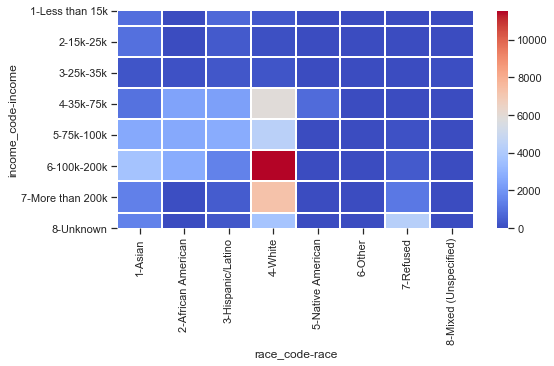

In [14]:
# create a heatmap of potential value 
# by both income and race which seem to be good candidates to segment the non-SF residents market by

pvs = nsf.pivot_table(index=['income_code','income'], columns=['race_code','race'], aggfunc='sum',
                      values='value').fillna(0)

plt.figure(figsize=(8,4))
sns.heatmap(pvs, cmap='coolwarm', linecolor='white', lw=1)
plt.show()

In [16]:
# output non-SF residents survey data to a csv file
# to input into Tableau for a more sophisticated heatmap

nsf[['respnum', 'sf_resident', 'county', 'gender','gender_code', 'race', 'race_code', 'income', 'income_code',
     'age', 'age_code', 'car_reason_hard', 'car_trips', 'taxi_trips', 'public_trips', 'mass_private_trips',
     'legs_trips', 'other_trips', 'targ_trips', 'targ_car_trips', 'targ_taxi_trips', 'targ_public_trips',
    'avg_travel_dist', 'value']].to_csv("data/nsf.csv")